# TP K-modes

K-mode is a variation of the k-means algorithm, adapted to deal with categorical features, the algorithm works like this : 
1. Utiliser une simple mesure de dissimilarité de correspondance pour les objets catégoriels,
2. Remplacer les moyens des clusters par les modes
3. Utiliser une méthode basée sur la fréquence pour actualiser les modes

# Commenet ça marche ?

Soit $x_{11}, x_{12},...,x_{nm}$ l'ensemble de données constitué de n objets avec m attributs. L'objectif principal de l'algorithme de kmodes est de regrouper les objets de données X en K clusters en minimisant la fonction de coût suivantes.

$$P(W,Q)=\sum_{l=1}^{k}\sum_{i=1}^{n}w_{il}d_{sim}(x_{i},q_{l})$$
Where $w_{fl}$ is an $N*K$ matrix where each element belongs to 0 or 1. $N$ is the total number of data objects and k is number of clusters. $d_{sim}(x_{i},q_{l})$ est la mésure de dissmiliraté et elle définie ainsi 
$$d_{sim}(x_{i},q_{l})=\sum_{j=1}^{m}\delta (x_{lj,q_{lj}})$$.
Le $\delta (x_{lj,z_{lj}})$ qui est la dissimiliraté est caluclé ainsi :
$$\delta (x_{lj,q_{lj}}) = \left\{\begin{matrix}
1 & si & x_{lj}=q_{lj}   \\ 
0 & si & x_{lj}\neq q_{lj}  
\end{matrix}\right.$$

# Déroulement de l'algorithme

**Étape 1** : Sélectionner au hasard les K modes initiaux des objets de données de telle sorte que Cj, j = 1,2,...,K 

**Étape 2** : Trouver la dissimilitude correspondante entre les K modes initiaux de chaque grappe et chaque objet de données en utilisant l'équation (2).

**Étape 3** : Évaluer l'adéquation à l'aide de l'équation (1)

**Étape 4** : Trouver les objets les plus proches des modes de regroupement initiaux.

**Étape 5** : Affecter les objets de données aux modes de centroïde de grappe les plus proches.

**Étape 6** : Mettre à jour les modes en appliquant la méthode basée sur la fréquence aux grappes nouvellement formées. 

**Étape 7** : Répétez les étapes 2,3,4 et 5 jusqu'à ce qu'il n'y ait plus de changement dans le vaisseau des objets de données. 

**Sortie** : Objets de données en cluster

In [165]:
import pandas as pd 
import time
import seaborn as sns
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from kmodes.kmodes import KModes

# Exemple de k-mode 

Dans cet exemple on déroule les deux algorithmes k-mode sur un dataset sur le cancer du sein collécté en 1988, le dataset ne contient que de variables qualitatifs, avec une colone **classe** no-recurrence-events et recurrence-events correspondant au fait qu'il s d'un cancer ou pas. On n'utilisera pas cette colonne en clustering mais pour comparer les algorithmes en clustering.

Le dataset contient 10 colonne : 

* **buying**       v-high, high, med, low
* **maint**        v-high, high, med, low
* **doors**        2, 3, 4, 5-more
* **persons**      2, 4, more
* **lug_boot**     small, med, big
* **safety**       low, med, high


   -- Matjaz Zwitter & Milan Soklic (physicians)
      Institute of Oncology 
      University Medical Center
      Ljubljana, Yugoslavia
   -- Donors: Ming Tan and Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
   -- Date: 11 July 1988

In [150]:
#Chargement du dataset
cols_names = ['buying', 'maint', 'doors',
              'persons', 'lug_boot', 'safety','constant']# read the data
df = pd.read_csv('car.csv',names=cols_names)
df=df.drop(columns=['constant'])
for column in df.columns:
    df[column]=df[column].astype(str)
df.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [100]:
#On elimine la colonne classe et on garde que les autres columns pour le clustering
y=df['buying']
train_X = df.drop(columns=['buying','maint'])

In [101]:
train_X.head()

,doors,persons,lug_boot,safety
0,2,2,small,low
1,2,2,small,med
2,2,2,small,high
3,2,2,med,low
4,2,2,med,med


On fait un encodage en label des métadonnée, l'algorithme k-mode permet d'utilisé un encodage en label meme si les traits ne sont pas ordinale 

In [102]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

d = defaultdict(LabelEncoder)

le = LabelEncoder()
train_X = train_X.apply(lambda x: d[x.name].fit_transform(x))

In [103]:
train_X

,doors,persons,lug_boot,safety
0,0,0,2,1
1,0,0,2,2
2,0,0,2,0
3,0,0,1,1
4,0,0,1,2
...,...,...,...,...
1723,3,2,1,2
1724,3,2,1,0
1725,3,2,0,1
1726,3,2,0,2


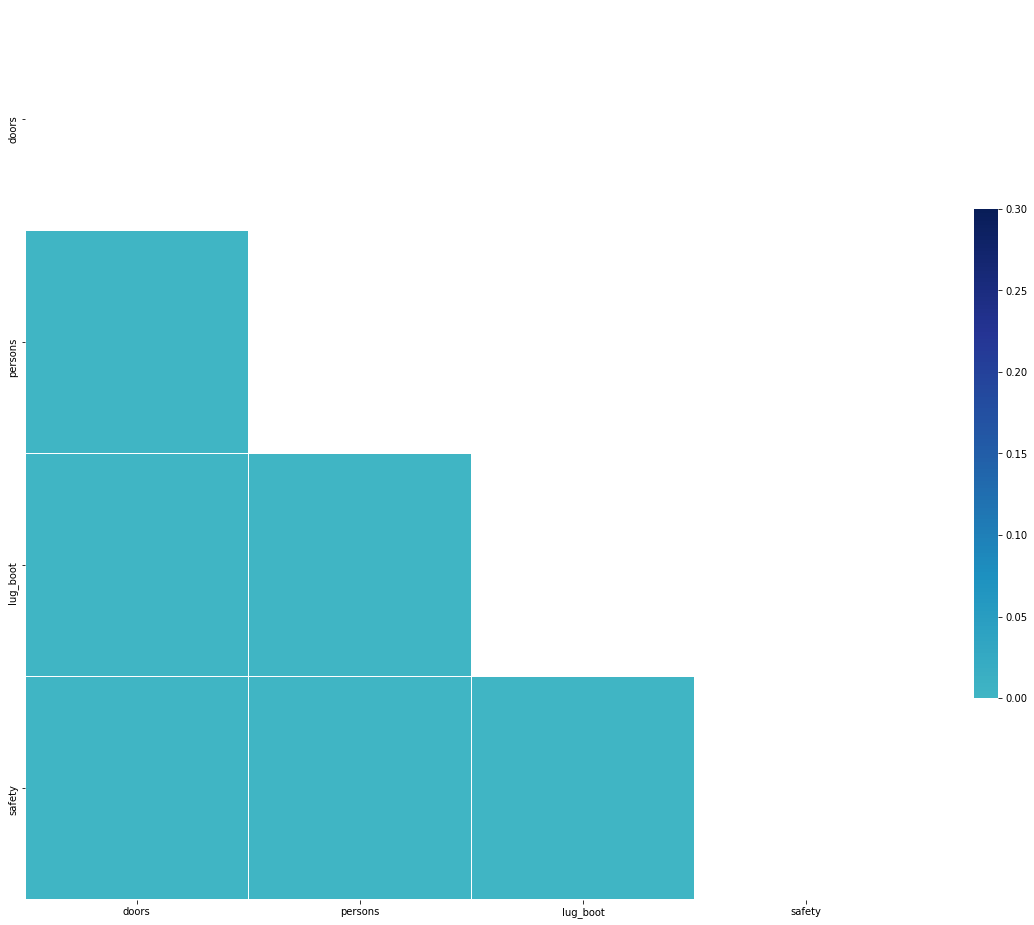

In [104]:
#Affichage des corrélation
corr = train_X.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="YlGnBu", vmax=.30, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

## Initialisation en K-modes 
Il existe trois type d'initialisation dans la litérature en k-modes
* Initialisation de Huang[1997, 1998] : la seconde méthode calcule les fréquences de toutes les catégories pour tous les attributs et attribue les catégories les plus fréquentes de manière égale aux K-modes initiaux.
* Initialisation de Cao al. [2009] : la méthode d'initialisation prend en compte la distance entre les objets et la densité des objets. elle sélectionne l'objet ayant la densité moyenne maximale comme premier centre de regroupement initial. Pour le calcul des autres centres de grappes, la distance entre l'objet et les grappes déjà connues, et la densité moyenne de l'objet sont prises en compte.La méthode vise à choisir un centre de grappes diversifié qui peut améliorer le regroupementrésultats, mais un critère uniforme pour la sélection des centres de clusters K-initial n'est pasfournis.
* Initlisation aléatoire: initilisation aléatoire

### Comparaison des trois initilisation

In [105]:
import numpy as np
import matplotlib.pyplot as plt 
cost_huang = []
cost_cao = []
cost_rand = []
for num_clusters in list(range(1,10)):
    kmode_cao = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=0)
    km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=0)
    km_rand = KModes(n_clusters=2, init = "random", n_init = 1, verbose=0)
    kmode_cao.fit_predict(train_X)
    km_huang.fit_predict(train_X)
    km_rand.fit_predict(train_X)
    cost_cao.append(kmode_cao.cost_)
    cost_huang.append(km_huang.cost_)
    cost_rand.append(km_rand.cost_)
x = np.array([i for i in range(1,10,1)])

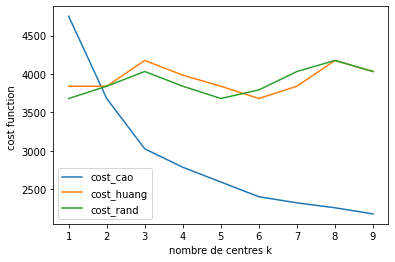

In [106]:
plt.plot(x, cost_cao, label = "cost_cao")
plt.plot(x, cost_huang, label = "cost_huang")
plt.plot(x, cost_rand, label = "cost_rand")
plt.xlabel('nombre de centres k')
plt.ylabel('cost function ')
plt.legend()
plt.show()

# Compraison des performance et vitesse

Dans cet partie on fait un clustering en 2 means parcequ'on sait que le dataset est binaire "selon la colone classe", 

In [107]:
km_cao = KModes(n_clusters=4, init = "cao", n_init = 1, verbose=0)
start_time = time.time()
fitClusters_cao = km_cao.fit_predict(train_X)
end_time = time.time()
print("le temps d'excution de 2-modes sur le dataset est",end_time-start_time)

le temps d'excution de 2-modes sur le dataset est 0.26299238204956055


## Affichage des cluster selon les modalité des classes
Dans cet section on affiche la distribution des classe selon les modalité des classes, cela permet de retrouvé les modes de chaque classe.

In [108]:
#Attacher la catégorie au dataframe
df_viz = df.copy()
df_viz['cluster']=fitClusters_cao

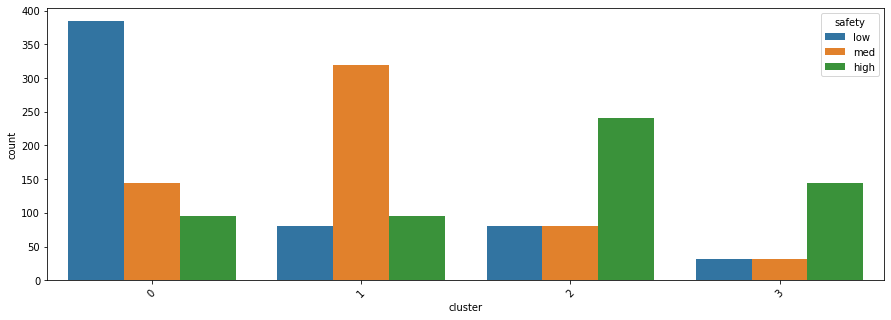

In [109]:
plt.subplots(figsize = (15,5))
g = sns.countplot(data=df_viz,x="cluster",hue="safety",orient="h")
plt.xticks(rotation=45);

In [ ]:
plt.subplots(figsize = (15,5))
g = sns.countplot(data=df_viz,x="cluster",hue="safety",orient="h")
plt.xticks(rotation=45);

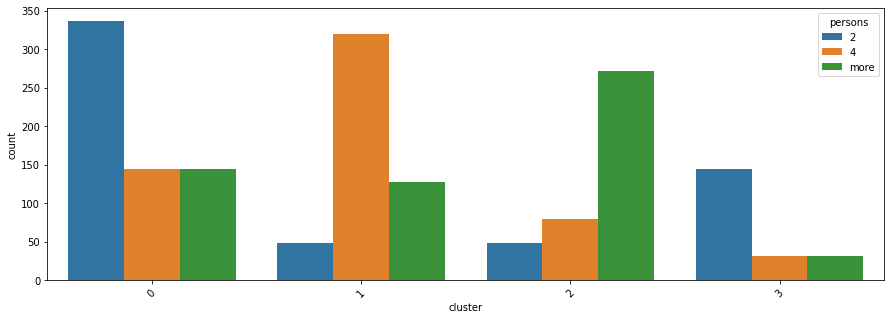

In [111]:
plt.subplots(figsize = (15,5))
g = sns.countplot(data=df_viz,x="cluster",hue="persons",orient="h")
plt.xticks(rotation=45);

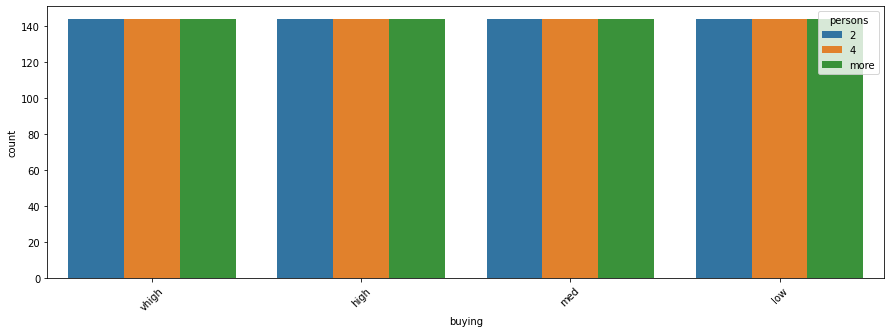

In [142]:
plt.subplots(figsize = (15,5))
g = sns.countplot(data=df_viz,x="buying",hue="persons",orient="h")
plt.xticks(rotation=45);

In [153]:
df_viz

,buying,maint,doors,persons,lug_boot,safety,cluster
0,vhigh,vhigh,2,2,small,low,0
1,vhigh,vhigh,2,2,small,med,0
2,vhigh,vhigh,2,2,small,high,0
3,vhigh,vhigh,2,2,med,low,0
4,vhigh,vhigh,2,2,med,med,0
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,1
1724,low,low,5more,more,med,high,3
1725,low,low,5more,more,big,low,2
1726,low,low,5more,more,big,med,2


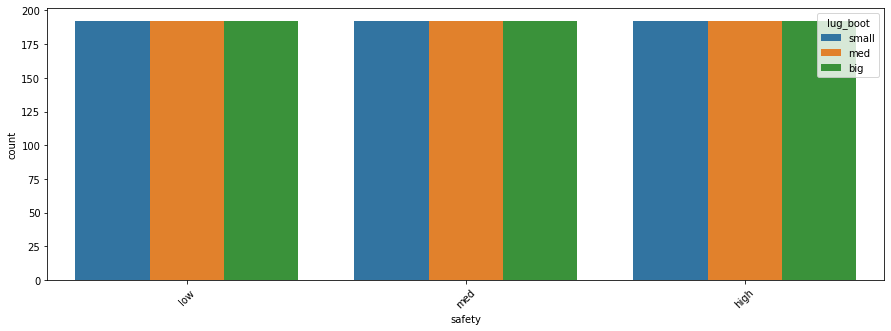

In [164]:
plt.subplots(figsize = (15,5))
g = sns.countplot(data=df_viz,x="safety",hue="lug_boot",orient="h")
plt.xticks(rotation=45);

In [163]:
pd.crosstab(df_viz['lug_boot'],df_viz['safety'])

safety,high,low,med
lug_boot,,,
big,192,192,192
med,192,192,192
small,192,192,192


In [114]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = df.drop(columns=['buying','maint']).columns
clusterCentroidsDf.apply(lambda x: d[x.name].inverse_transform(x))

,doors,persons,lug_boot,safety
0,2,2,small,low
1,3,4,med,med
2,4,more,big,high
3,5more,2,med,high


## Visualisation des performance du model

Dans cet section on test les performance du model sur plusieurs métriques, en utilisant effectif du dataset

In [117]:
from sklearn import metrics
labels_true = LabelEncoder().fit_transform(df['buying'])

In [118]:
# Homogénité 
metrics.adjusted_mutual_info_score(fitClusters_cao,labels_true)

-0.0019340978253616103

In [119]:
#Complitude 
metrics.fowlkes_mallows_score(labels_true, fitClusters_cao)

0.2633753539813986

In [120]:
metrics.v_measure_score(labels_true, fitClusters_cao)

1.2308744863222392e-16

In [121]:
metrics.adjusted_mutual_info_score(labels_true, fitClusters_cao)

-0.0019340978253633949

## Compraison de la vitessse et performance avec k-means

Il est démontré que l'algorithme permet d'obtenir une convergence avec les la complexité temporelle en ce qui concerne le nombre d'objets de données. Les hauteurs soulignent également qu'en général, l'algorithme des modes K est plus rapide que l'algorithme des moyennes K car il nécessite moins d'itérations pour converger.

Dans cette partie on va comparer la vitesse d'un k-means appliqué sur les donnée encodé en oneHotencoding et l'algorithme k-mode

In [122]:
X_train_kmeans = pd.get_dummies(df.drop(columns=['buying','maint']),drop_first=True)
X_train_kmeans

,doors_3,doors_4,doors_5more,persons_4,persons_more,lug_boot_med,lug_boot_small,safety_low,safety_med
0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,1,0,1
2,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1723,0,0,1,0,1,1,0,0,1
1724,0,0,1,0,1,1,0,0,0
1725,0,0,1,0,1,0,0,1,0
1726,0,0,1,0,1,0,0,0,1


In [123]:
from sklearn.cluster import KMeans
import time 

start_time = time.time()
fitClusters_kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X_train_kmeans)
end_time = time.time()
end_time-start_time

1.021265983581543

In [124]:
fitClusters_kmeans

array([1, 0, 0, ..., 1, 0, 0], dtype=int32)

Une meilleure etude des cluster consisetra a les caractésisé avec les variables qualtitatives et les modalité de chaque variables en utilisant les test statistiques. 

In [125]:
from sklearn import metrics

In [126]:
metrics.adjusted_mutual_info_score(labels_true, fitClusters_kmeans)

-0.0008604612737865609

In [127]:
metrics.adjusted_mutual_info_score(labels_true, fitClusters_kmeans)

-0.0008604612737865609

In [128]:
metrics.fowlkes_mallows_score(labels_true, fitClusters_kmeans)

0.3717491312509271